# Results

## Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sys
import os
import random
import math

from matplotlib import pyplot as plt

from PIL import Image

from dotenv import load_dotenv

In [2]:
sys.path.append("../Library/")
import deep_learning as dl
import image_manipulation as ima
import machine_learning as ml
#import present_results as pr
#import display as pr

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
%load_ext autoreload
%autoreload 2

In [42]:
PATH_GDRIVE = os.getenv('GDRIVE_FOLDER')
PATH_IMAGES = os.path.join(PATH_GDRIVE, "MFP - Satellogic/images/")
PATH_RESULTS = os.path.join(PATH_GDRIVE.replace("MDS/",""), 'COLAB/MasterThesis/Results')

CATEGORIES = ["forest-woodland", "agriculture", "shrubland-grassland", "semi-desert"]
CATEGORY_COLOR = {
    "forest-woodland": "green",
    "agriculture": "lime",
    "shrubland-grassland": "saddlebrown",
    "semi-desert": "sandybrown",
    "all-0.3m": "blue",
    "all-1m": "indigo",
}

labels = [0, 1, 2]

fig_filename_formatter = "../report/Figures/results/{}.png"
tab_filename_formatter = "../report/Tables/{}.tex"

In [43]:
def load_results(folder):
    count = 0
    for file in os.listdir(folder):
        if file.startswith('result') and count == 0:
            df_results = pd.read_csv(os.path.join(folder, file), )
            count += 1
        elif file.startswith('result') and count > 0:
            df_results = df_results.append(pd.read_csv(os.path.join(folder, file)))
            count += 1
    return df_results


def load_grouped_results(path, acc_threshold):
    df_results = load_results(path)
    df_results = df_results[df_results["accuracy"] > acc_threshold]
    grouped_results = df_results.groupby(['resolution'], as_index=False).agg({
        'accuracy':['mean','std'], 
        'accuracy_agriculture':['mean','std'],
        'accuracy_forest-woodland':['mean','std'],
        'accuracy_semi-desert':['mean','std'],
        'accuracy_shrubland-grassland':['mean','std'],
    })
    return grouped_results


def export_to_latex(df, fname):
    DECIMALS = 4
    
    latex_table = df.to_latex(
        index=False,
        multirow=True,
        multicolumn_format="c",
        float_format="%.{}f".format(DECIMALS),
    )
    
    latex_table = latex_table.replace("resolution","res.")
    latex_table = latex_table.replace("accuracy\_","")
    latex_table = latex_table.replace("accuracy","All categories")
    latex_table = latex_table.replace("mean","mean acc.")
    #latex_table = latex_table.replace("-","-\n")
    
    with open(fname, "w") as f:
        f.write(latex_table)
        
    return latex_table


def load_res_and_sizes(base_res, base_size, n_res):
    sizes = {base_res: (base_size, base_size)}
    for factor in range(2, n_res):
        res = round(base_res * factor,1)
        size = round(base_size/factor)
        sizes[res] = (size, size)
    print("Sizes dictionary:\n", sizes)
    return sizes


def get_misclf_indcs_outersection(X, y, df_results, res1, res2):

    _, _, high_res_indcs = pr.get_misclf_or_correctclf_images(
        X, y, df_results, res =res1, n = None, misclf = True
    )

    _, _, low_res_indcs = pr.get_misclf_or_correctclf_images(
        X, y, df_results, res = res2, n = None, misclf = True
    )
    
    high_minus_low = list(set(high_res_indcs) - set(low_res_indcs))
    low_minus_high = list(set(low_res_indcs) - set(high_res_indcs))
    
    return high_minus_low, low_minus_high

---

## History

Convergence history for each dataset and all resolutions

In [44]:
if False:
    inch_per_plot = 4
    fig = plt.figure()
    array_width = 4
    array_height = math.ceil(results_df.shape[0]/array_width)
    fig.set_size_inches(array_width*inch_per_plot,array_height*inch_per_plot)

    for index, row in results_df.iterrows():
        ax = fig.add_subplot(array_height,array_width,index+1) 
        ax.set_title("Accuracy VS Epochs (" + str(row["resolution"]) + ")")
        plt.plot(row["history"].history['acc'], label="train")
        plt.plot(row["history"].history['val_acc'], label="test")
        #ax.grid()
        ax.legend(loc='lower right')

    plt.show()

---

## Accuracy vs Resolution - Tables

### 0.3m dataset

In [45]:
ACC_THRESHOLD = 0.6
RES_NAME = "0.3"

path_results_res = os.path.join(PATH_RESULTS, RES_NAME + 'm')
grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)
export_to_latex(grouped_results, tab_filename_formatter.format("Ch5_Results_03m"))
grouped_results

resolution  accuracy           accuracy_agriculture            \
                   mean       std                 mean       std   
0         0.3  0.958468  0.019014             0.985801  0.015787   
1         0.6  0.938265  0.019016             0.969895  0.021593   
2         0.9  0.934746  0.009557             0.943872  0.024420   
3         1.2  0.927126  0.012002             0.948765  0.037394   
4         1.5  0.928771  0.013940             0.962184  0.028457   
5         1.8  0.922409  0.015422             0.967825  0.031056   
6         2.1  0.910773  0.024092             0.961836  0.016807   
7         2.4  0.912029  0.020598             0.957317  0.027975   
8         2.7  0.895206  0.022289             0.961970  0.021555   
9         3.0  0.889296  0.018882             0.957148  0.006661   
10        3.3  0.895711  0.020866             0.953899  0.031140   
11        3.6  0.878415  0.018419             0.941467  0.039353   
12        3.9  0.881912  0.015263             0.945648  0.018602   
13        4.2  0.880370  0.007048             0.938883  0.030532   
14        4.5  0.871494  0.017946             0.938299  0.038992   
15        4.8  0.869008  0.016007             0.950759  0.015717   

   accuracy_forest-woodland           accuracy_semi-desert            \
                       mean       std                 mean       std   
0                  0.897763  0.026922             0.942839  0.041212   
1                  0.877914  0.026879             0.923058  0.041007   
2                  0.894400  0.056081             0.932717  0.021628   
3                  0.906050  0.037328             0.914980  0.032830   
4                  0.867915  0.038284             0.914447  0.030946   
5                  0.886371  0.065021             0.901365  0.036287   
6                  0.874926  0.045413             0.888503  0.057141   
7                  0.868646  0.059010             0.886732  0.035779   
8                  0.863125  0.019130             0.851036  0.034991   
9                  0.871697  0.019733             0.833952  0.047234   
10                 0.872257  0.047933             0.852916  0.034093   
11                 0.872656  0.044166             0.819935  0.034795   
12                 0.873805  0.033042             0.839721  0.036401   
13                 0.852513  0.026730             0.844391  0.053305   
14                 0.844512  0.030770             0.830137  0.034045   
15                 0.856920  0.051714             0.779826  0.045557   

   accuracy_shrubland-grassland            
                           mean       std  
0                      0.989177  0.012493  
1                      0.974806  0.019762  
2                      0.957836  0.021177  
3                      0.939917  0.023142  
4                      0.960408  0.021484  
5                      0.937062  0.022055  
6                      0.921566  0.037127  
7                      0.935212  0.026292  
8                      0.911657  0.049580  
9                      0.905505  0.045453  
10                     0.912149  0.042453  
11                     0.893477  0.029884  
12                     0.879647  0.017764  
13                     0.896066  0.022232  
14                     0.882137  0.020640  
15                     0.903548  0.031026

### 1m dataset

In [46]:
ACC_THRESHOLD = 0.6
RES_NAME = "1"

path_results_res = os.path.join(PATH_RESULTS, RES_NAME + 'm')
grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)
export_to_latex(grouped_results, tab_filename_formatter.format("Ch5_Results_1m"))
grouped_results

resolution  accuracy           accuracy_agriculture            \
                   mean       std                 mean       std   
0           1  0.910100  0.019632             0.982615  0.027695   
1           2  0.900094  0.013844             0.980324  0.030561   
2           3  0.904097  0.024647             0.984568  0.024614   
3           4  0.897026  0.022725             0.984568  0.024614   
4           5  0.886545  0.039145             0.980867  0.032777   
5           6  0.879984  0.028180             0.967303  0.035159   
6           7  0.858652  0.034998             0.958375  0.048194   
7           8  0.869876  0.022956             0.983135  0.028872   
8           9  0.833799  0.014761             0.934083  0.056158   
9          10  0.823436  0.026298             0.991071  0.025254   
10         11  0.821907  0.024852             0.970328  0.064477   
11         12  0.811222  0.025720             0.948995  0.033262   
12         13  0.814682  0.036924             0.966648  0.048840   
13         14  0.783675  0.016724             0.935069  0.069046   
14         15  0.780844  0.024457             0.945724  0.028914   
15         16  0.798952  0.036077             0.940315  0.063495   

   accuracy_forest-woodland           accuracy_semi-desert            \
                       mean       std                 mean       std   
0                  0.914104  0.068703             0.891827  0.039439   
1                  0.899132  0.063413             0.884314  0.041326   
2                  0.924450  0.027999             0.874160  0.053739   
3                  0.874281  0.028024             0.878636  0.048131   
4                  0.869207  0.057679             0.882052  0.032818   
5                  0.868454  0.046659             0.841909  0.046863   
6                  0.835973  0.065331             0.846813  0.058331   
7                  0.878822  0.044231             0.843203  0.030340   
8                  0.833014  0.056481             0.808583  0.043082   
9                  0.815869  0.055256             0.781525  0.042020   
10                 0.805180  0.050682             0.790128  0.053773   
11                 0.817777  0.036247             0.760605  0.036320   
12                 0.798840  0.092100             0.771934  0.072322   
13                 0.768235  0.040317             0.739832  0.054289   
14                 0.766316  0.067270             0.725676  0.047195   
15                 0.767976  0.070030             0.771285  0.085726   

   accuracy_shrubland-grassland            
                           mean       std  
0                      0.897994  0.049904  
1                      0.888068  0.042962  
2                      0.880510  0.031484  
3                      0.912918  0.022224  
4                      0.879672  0.047187  
5                      0.909325  0.050796  
6                      0.868185  0.059842  
7                      0.849780  0.033460  
8                      0.824495  0.054280  
9                      0.819885  0.069980  
10                     0.819260  0.070230  
11                     0.811787  0.081432  
12                     0.824403  0.057183  
13                     0.799910  0.039714  
14                     0.801714  0.043941  
15                     0.814055  0.076358

---

## Accuracy vs Resolution

Accuracy for each resolution of the datasets

### 0.3m dataset

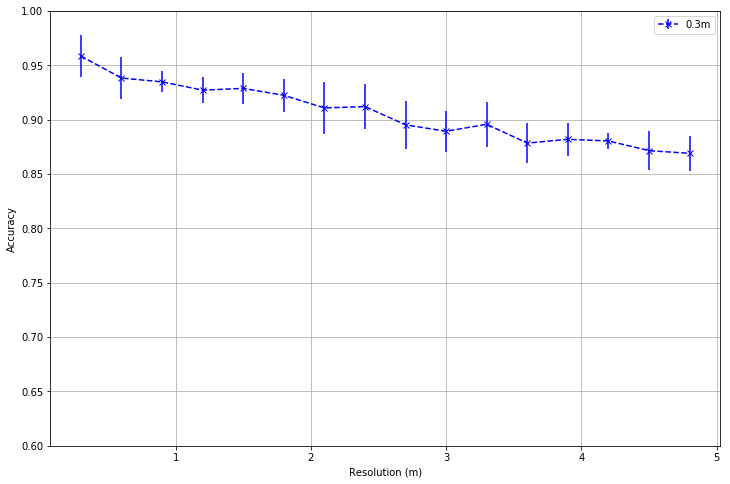

In [47]:
ACC_THRESHOLD = 0.6
RES_NAME = "0.3"

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

path_results_res = os.path.join(PATH_RESULTS, RES_NAME + 'm')
grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)

ax.errorbar(
    grouped_results["resolution"], grouped_results.accuracy["mean"], grouped_results.accuracy["std"],
    linestyle='dashed', marker='x', label=RES_NAME+"m", color=CATEGORY_COLOR["all-"+RES_NAME+"m"],
)  

ax.set(
    xlabel="Resolution (m)",
    ylabel="Accuracy",
    #title = "Classification accuracy vs resolution",
    ylim=(0.6,1)
)
ax.grid()
ax.legend()

plt.show()
fig.savefig(fig_filename_formatter.format("acc_res_03m"), bbox_inches='tight')

### 1m dataset

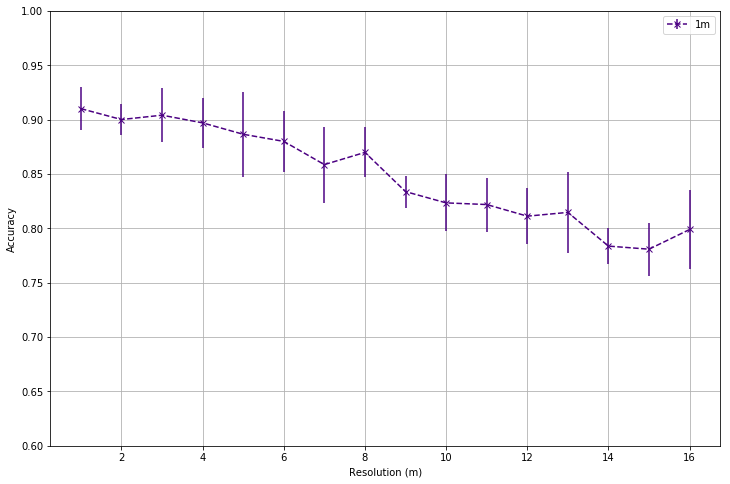

In [48]:
ACC_THRESHOLD = 0.6
RES_NAME = "1"

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

path_results_res = os.path.join(PATH_RESULTS, RES_NAME + 'm')
grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)

ax.errorbar(
    grouped_results["resolution"], grouped_results.accuracy["mean"], grouped_results.accuracy["std"],
    linestyle='dashed', marker='x', label=RES_NAME+"m", color=CATEGORY_COLOR["all-"+RES_NAME+"m"],
)  

ax.set(
    xlabel="Resolution (m)",
    ylabel="Accuracy",
    #title = "Classification accuracy vs resolution",
    ylim=(0.6,1)
)
ax.grid()
ax.legend()

plt.show()
fig.savefig(fig_filename_formatter.format("acc_res_1m"), bbox_inches='tight')

### All datasets

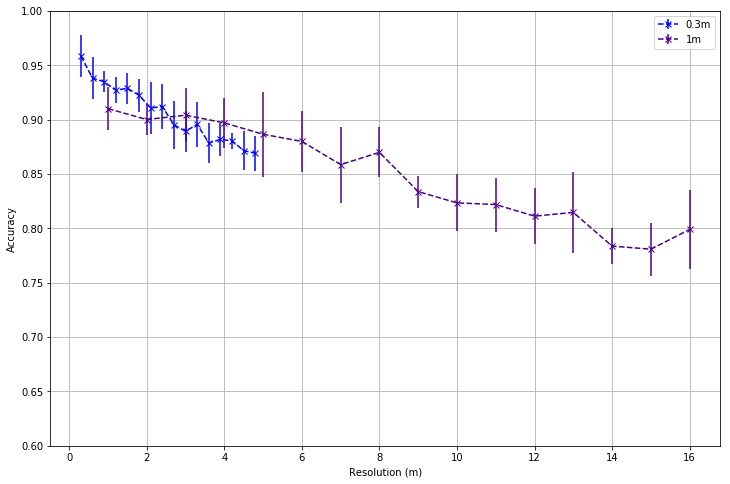

In [49]:
ACC_THRESHOLD = 0.6
RES_NAMES = [
    "0.3", 
    #"0.3-1", 
    "1"
]

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

for res_name in RES_NAMES:
    path_results_res = os.path.join(PATH_RESULTS, res_name + 'm')
    grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)
    
    ax.errorbar(
        grouped_results["resolution"], grouped_results.accuracy["mean"], grouped_results.accuracy["std"],
        linestyle='dashed', marker='x', label=res_name+"m", color=CATEGORY_COLOR["all-"+res_name+"m"],
    )  

ax.set(
    xlabel="Resolution (m)",
    ylabel="Accuracy",
    #title = "Classification accuracy vs resolution",
    ylim=(0.6,1)
)
ax.grid()
ax.legend()

plt.show()
fig.savefig(fig_filename_formatter.format("acc_res_03m_1m"), bbox_inches='tight')

---

## Accuracy by category

### 0.3m dataset

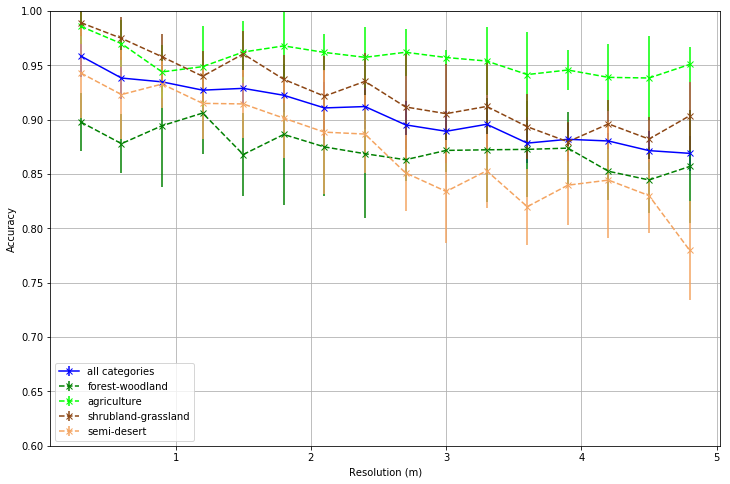

In [50]:
ACC_THRESHOLD = 0.6
RES_NAME = "0.3"

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

path_results_res = os.path.join(PATH_RESULTS, RES_NAME + 'm')
grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)

ax.errorbar(
    grouped_results["resolution"], grouped_results["accuracy"]["mean"], grouped_results["accuracy"]["std"],
    #linestyle='dashed', 
    marker='x', 
    color=CATEGORY_COLOR["all-"+RES_NAME+"m"],
    label="all categories"
) 

for cat in CATEGORIES:
    acc = "accuracy_"+cat
    ax.errorbar(
        grouped_results["resolution"], grouped_results[acc]["mean"], grouped_results[acc]["std"],
        linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR[cat],
        label=cat
    ) 

ax.set(
    xlabel="Resolution (m)",
    ylabel="Accuracy",
    #title = "Classification accuracy vs resolution",
    ylim=(0.6,1)
)
ax.grid()
ax.legend()

plt.show()
fig.savefig(fig_filename_formatter.format("acc_res_all_categories_03m"), bbox_inches='tight')

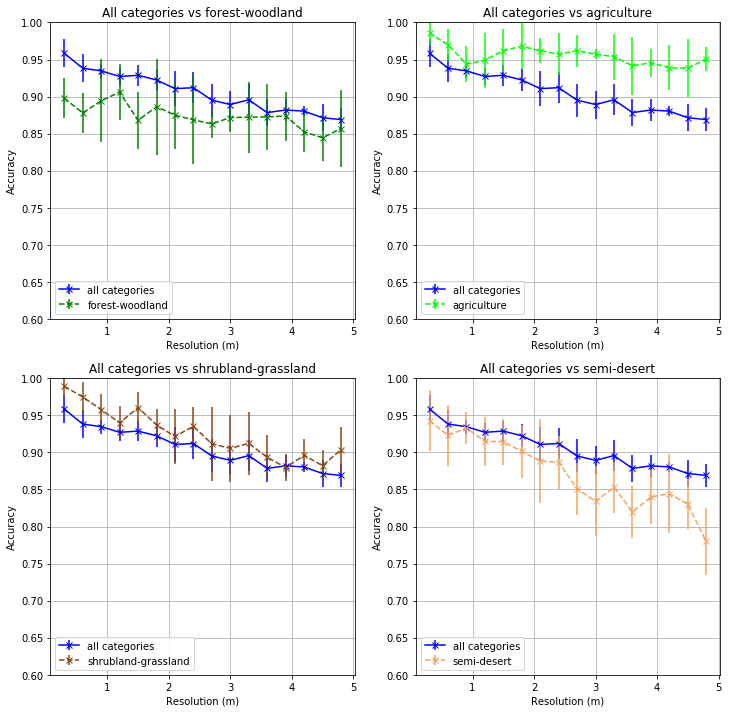

In [51]:
inch_per_plot = 6
fig = plt.figure()
array_width = 2
array_height = math.ceil(len(CATEGORIES)/array_width)
fig.set_size_inches(array_width*inch_per_plot,array_height*inch_per_plot)

for index, cat in enumerate(CATEGORIES):
    ax = fig.add_subplot(array_height,array_width,index+1) 

    ax.errorbar(
        grouped_results["resolution"], grouped_results["accuracy"]["mean"], grouped_results["accuracy"]["std"],
        #linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR["all-"+RES_NAME+"m"],
        label="all categories"
    ) 

    acc = "accuracy_"+cat
    ax.errorbar(
        grouped_results["resolution"], grouped_results[acc]["mean"], grouped_results[acc]["std"],
        linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR[cat],
        label=cat
    ) 

    ax.set(
        xlabel="Resolution (m)",
        ylabel="Accuracy",
        title = "All categories vs " + cat,
        ylim=(0.6,1)
    )
    ax.grid()
    ax.legend(loc='lower left')

plt.show()
fig.savefig(fig_filename_formatter.format("acc_res_by_category_03m"), bbox_inches='tight')

### 1m dataset

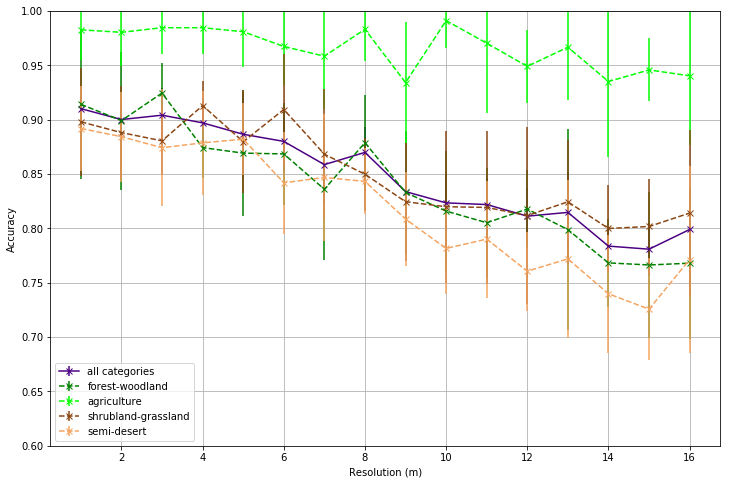

In [52]:
ACC_THRESHOLD = 0.6
RES_NAME = "1"

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

path_results_res = os.path.join(PATH_RESULTS, RES_NAME + 'm')
grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)

ax.errorbar(
    grouped_results["resolution"], grouped_results["accuracy"]["mean"], grouped_results["accuracy"]["std"],
    #linestyle='dashed', 
    marker='x', 
    color=CATEGORY_COLOR["all-"+RES_NAME+"m"],
    label="all categories"
) 

for cat in CATEGORIES:
    acc = "accuracy_"+cat
    ax.errorbar(
        grouped_results["resolution"], grouped_results[acc]["mean"], grouped_results[acc]["std"],
        linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR[cat],
        label=cat
    ) 

ax.set(
    xlabel="Resolution (m)",
    ylabel="Accuracy",
    #title = "Classification accuracy vs resolution",
    ylim=(0.6,1)
)
ax.grid()
ax.legend()

plt.show()
fig.savefig(fig_filename_formatter.format("acc_res_all_categories_1m"), bbox_inches='tight')

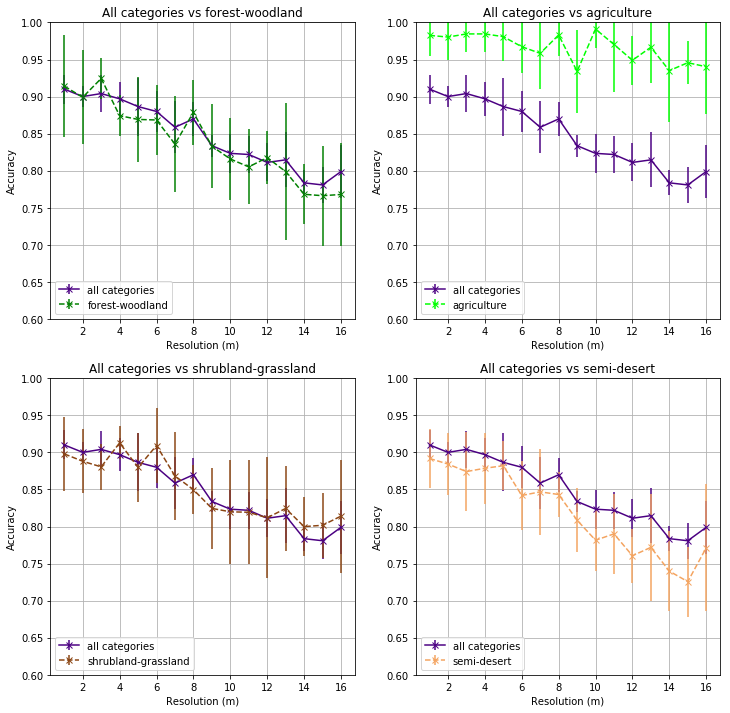

In [53]:
inch_per_plot = 6
fig = plt.figure()
array_width = 2
array_height = math.ceil(len(CATEGORIES)/array_width)
fig.set_size_inches(array_width*inch_per_plot,array_height*inch_per_plot)

for index, cat in enumerate(CATEGORIES):
    ax = fig.add_subplot(array_height,array_width,index+1) 

    ax.errorbar(
        grouped_results["resolution"], grouped_results["accuracy"]["mean"], grouped_results["accuracy"]["std"],
        #linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR["all-"+RES_NAME+"m"],
        label="all categories"
    ) 

    acc = "accuracy_"+cat
    ax.errorbar(
        grouped_results["resolution"], grouped_results[acc]["mean"], grouped_results[acc]["std"],
        linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR[cat],
        label=cat
    ) 

    ax.set(
        xlabel="Resolution (m)",
        ylabel="Accuracy",
        title = "All categories vs " + cat,
        ylim=(0.6,1)
    )
    ax.grid()
    ax.legend(loc='lower left')

plt.show()
fig.savefig(fig_filename_formatter.format("acc_res_by_category_1m"), bbox_inches='tight')

### All datasets

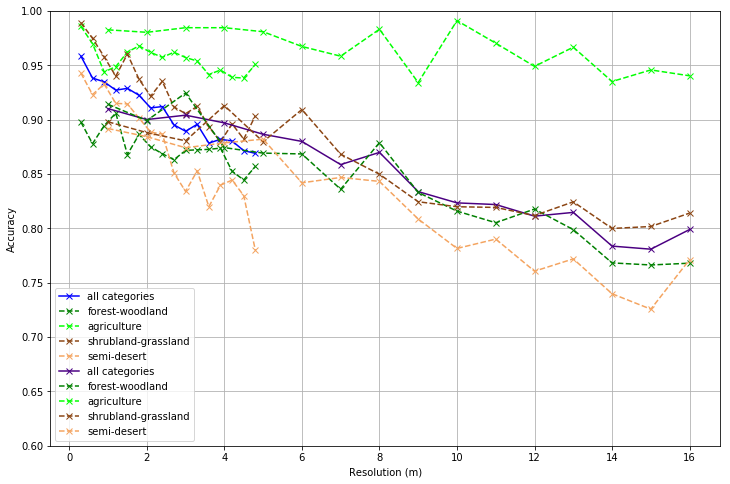

In [55]:
ACC_THRESHOLD = 0.6
RES_NAMES = [
    "0.3", 
    #"0.3-1", 
    "1"
]

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

for res_name in RES_NAMES:
    path_results_res = os.path.join(PATH_RESULTS, res_name + 'm')
    grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)
    
    ax.errorbar(
        grouped_results["resolution"], grouped_results["accuracy"]["mean"],# grouped_results["accuracy"]["std"],
        #linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR["all-"+res_name+"m"],
        label="all categories"
    ) 

    for cat in CATEGORIES:
        acc = "accuracy_"+cat
        ax.errorbar(
            grouped_results["resolution"], grouped_results[acc]["mean"],# grouped_results[acc]["std"],
            linestyle='dashed', 
            marker='x', 
            color=CATEGORY_COLOR[cat],
            label=cat
        ) 

ax.set(
    xlabel="Resolution (m)",
    ylabel="Accuracy",
    #title = "Classification accuracy vs resolution",
    ylim=(0.6,1)
)
ax.grid()
ax.legend()

plt.show()







---

In [17]:
stop here

SyntaxError: invalid syntax (<ipython-input-17-a96ba3aab008>, line 1)

## Resolution 0.3m

In [ ]:
base_res = 0.3
base_size = 512
N_RES = 17
sizes = load_res_and_sizes(base_res, base_size, N_RES)

path_results_res = os.path.join(PATH_RESULTS, 'Results_' + str(base_res) + 'm_excl_label1')
df_results = load_results(path_results_res)

### Load Images that were used to train the model

In [ ]:
X = np.load(os.path.join(path_results_res, "X_images_res" + str(base_res) + ".npy"))
y = np.load(os.path.join(path_results_res, "y_images_res" + str(base_res) + ".npy"))

### Correctly Classified Images at Resolution 0.6

In [ ]:
res = 0.6

X_correct_class, y_real_label, _ = pr.get_misclf_or_correctclf_images(
    X, y, df_results, res = res, n = 100, misclf = False
)
pr.plot_misclf_or_correctclf_images(
    X_correct_class, y_real_label, columns = 4, misclf = False, degrade = sizes[res]
)

### Wrongly Classified Images at Resolution 0.6

In [ ]:
res = 0.6

X_wrong_class, y_real_label, _ = pr.get_misclf_or_correctclf_images(
    X, y, df_results, res = res, n = 50, misclf = True
)
pr.plot_misclf_or_correctclf_images(
    X_wrong_class, y_real_label, columns = 4, misclf = True, degrade = sizes[res]
)

### Correctly Classified Images at Resolution 4.8

In [ ]:
res = 4.8

X_correct_class, y_real_label, _ = pr.get_misclf_or_correctclf_images(
    X, y, df_results, res = res, n = 100, misclf = False
)
pr.plot_misclf_or_correctclf_images(
    X_correct_class, y_real_label, columns = 4, misclf = False, degrade = sizes[res]
)

### Wrongly Classified Images at Resolution 4.8

In [ ]:
res = 4.8

X_wrong_class, y_real_label, _ = pr.get_misclf_or_correctclf_images(
    X, y, df_results, res = res, n = 50, misclf = True
)
pr.plot_misclf_or_correctclf_images(
    X_wrong_class, y_real_label, columns = 4, misclf = True, degrade = sizes[res]
)

### Images that were classified correct at 0.6 and wrong at 4.8

In [ ]:
misclf_high, misclf_low = get_misclf_indcs_outersection(X, y, df_results, 0.6, 4.8)

In [ ]:
pr.plot_misclf_or_correctclf_images(
    X[misclf_low], y[misclf_low], n = 20, columns = 4, misclf = False, degrade = sizes[0.6]
)

In [ ]:
pr.plot_misclf_or_correctclf_images(
    X[misclf_low], y[misclf_low], n = 20, columns = 4, misclf = True, degrade = sizes[4.8]
)

### Classify images of label 1

In [ ]:
X_l1_path = os.path.join(path_results_res, 'X_l1_images_res0.3.npy')
y_l1_path = os.path.join(path_results_res, 'y_l1_images_res0.3.npy')

X_l1_base = np.load(X_l1_path)
y_l1_base = np.load(y_l1_path, allow_pickle = True)

RESOLUTION = 1.2

In [ ]:
base_model = ResNet50(weights='imagenet',
                      include_top=False
                     )

In [ ]:
base_model.summary()

In [ ]:
X_act_flat = dl.preprocess_activations(X_l1_base, sizes[RESOLUTION], base_model, activation_name="activation_49")

In [ ]:
models = ml.load_ensemble_models(path_results_res, RESOLUTION, num_folds = 8)
yhats = ml.ensemble_predictions(models, X_act_flat)

indcs = random.sample(range(len(yhats)), k=len(yhats))
pr.plot_misclf_or_correctclf_images(X_l1_base[indcs], yhats[indcs], 
                                    n = 50,
                                    degrade = sizes[RESOLUTION],
                                    show_real_label = False)

---

## Resolution 1m

In [ ]:
base_res = 1
base_size = 512
N_RES = 17
sizes = load_res_and_sizes(base_res, base_size, N_RES)

path_results_res = os.path.join(PATH_RESULTS, 'Results_' + str(base_res) + 'm_excl_label1')
df_results = load_results(path_results_res)

### Load Images that were used to train the model

In [ ]:
X = np.load(os.path.join(path_results_res, "X_images_res" + str(base_res) + ".npy"))
y = np.load(os.path.join(path_results_res, "y_images_res" + str(base_res) + ".npy"))

### Correctly Classified Images at Resolution 2

In [ ]:
res = 2

X_correct_class, y_real_label, _ = pr.get_misclf_or_correctclf_images(
    X, y, df_results, res = res, n = 100, misclf = False
)
pr.plot_misclf_or_correctclf_images(
    X_correct_class, y_real_label, columns = 4, misclf = False, degrade = sizes[res]
)

### Wrongly Classified Images at Resolution 2

In [ ]:
res = 2

X_wrong_class, y_real_label, _ = pr.get_misclf_or_correctclf_images(
    X, y, df_results, res = res, n = 50, misclf = True
)
pr.plot_misclf_or_correctclf_images(
    X_wrong_class, y_real_label, columns = 4, misclf = True, degrade = sizes[res]
)

### Correctly Classified Images at Resolution 16

In [ ]:
res = 16

X_correct_class, y_real_label, _ = pr.get_misclf_or_correctclf_images(
    X, y, df_results, res = res, n = 100, misclf = False
)
pr.plot_misclf_or_correctclf_images(
    X_correct_class, y_real_label, columns = 4, misclf = False, degrade = sizes[res]
)

### Wrongly Classified Images at Resolution 16

In [ ]:
res = 16

X_wrong_class, y_real_label, _ = pr.get_misclf_or_correctclf_images(
    X, y, df_results, res = res, n = 50, misclf = True
)
pr.plot_misclf_or_correctclf_images(
    X_wrong_class, y_real_label, columns = 4, misclf = True, degrade = sizes[res]
)

### Images that were classified correct at 2 and wrong at 16

In [ ]:
misclf_high, misclf_low = get_misclf_indcs_outersection(X, y, df_results, 2, 16)

In [ ]:
pr.plot_misclf_or_correctclf_images(
    X[misclf_low], y[misclf_low], n = 20, columns = 4, misclf = False, degrade = sizes[2]
)

In [ ]:
pr.plot_misclf_or_correctclf_images(
    X[misclf_low], y[misclf_low], n = 20, columns = 4, misclf = True, degrade = sizes[16]
)

---
---

# Deprecated

In [ ]:
FOLDS = [0, 1, 2, 3, 4, 5, 6, 7]

RESOLUTIONS = [2.4, 2.7]    

new_models = {}

for res in RESOLUTIONS:

    models = []
    for fold in FOLDS:
        fullpath = os.path.join(PATH_RESULTS, "model_res" + str(res) + "_fold" + str(fold))
        models.append(dl.load_keras_model(fullpath))

    weights = [model.get_weights() for model in model_inner]

    new_weights = list()

    for weights_list_tuple in zip(*weights):
        new_weights.append(
            [np.array(weights_).mean(axis=0)\
                for weights_ in zip(*weights_list_tuple)])

    new_model_inner = model_inner[0]
    new_model_inner.set_weights(new_weights)
    
    new_models[res] = new_model_inner

# Wrongly classified high resolution vs low resolution (optional)

### TODO: Write explanation here

In [ ]:
resolutions = np.linspace(0.6, 4.8, num = 15)
step = 0.3

misclf_high_list = []
misclf_low_list = []
for res in resolutions[1:].round(1):
    misclf_high, misclf_low = get_misclf_indcs_outersection(X, y, df_results, round(res - step,1), res)
    misclf_high_list.append(len(misclf_high))
    misclf_low_list.append(len(misclf_low))

plt.figure()
plt.plot(resolutions[:-1].tolist(), misclf_low_list, label = "No. img. misclf. low resolution")
plt.plot(resolutions[:-1].tolist(), misclf_high_list, label = "No. img. misclf. high resolution")
plt.legend()
plt.show()

### TODO: Write explanation here

In [ ]:
resolutions = np.linspace(0.6, 4.8, num = 15)
step = 0.3

misclf_high_list = []
misclf_low_list = []
for res in resolutions[1:].round(1):
    misclf_high, misclf_low = get_misclf_indcs_outersection(X, y, df_results, 0.6, res)
    misclf_high_list.append(len(misclf_high))
    misclf_low_list.append(len(misclf_low))

plt.figure()
plt.plot(resolutions[:-1].tolist(), misclf_low_list, label = "High res right, low resolution wrong")
plt.plot(resolutions[:-1].tolist(), misclf_high_list, label = "High res wrong, low resolution right")
plt.legend()
plt.show()